In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')

***Data Cleaning and Exploration***

In [3]:
epi = pd.read_csv('data/dataframes/epi_wrangled.csv')

- Remove countries with fewer than 5 records.

In [4]:
high_data = [key for key, value in epi['country_name'].value_counts().to_dict().items() if value >5]

In [5]:
epi = epi[epi['country_name'].isin(high_data)]

In [6]:
epi['country_name'].value_counts()

Kenya                               19
Argentina                           19
Serbia                              19
Suriname                            19
Zimbabwe                            19
                                    ..
Marshall Islands                     9
Sao Tome and Principe                9
Micronesia                           9
Saint Vincent and the Grenadines     9
Saint Lucia                          9
Name: country_name, Length: 185, dtype: int64

- Linearly impute values in place of nulls.

In [7]:
def impute_values(country_name):
    country = epi[epi['country_name'] == country_name].copy()
    for col in country.columns:
        country[col] = country[col].map(lambda x: np.nan if x == 'None' else x)
        country[col].interpolate(method='linear',order=1,inplace=True, axis=0)
    return country
        

In [8]:
epi_new = pd.DataFrame()

for country_name in  set(epi['country_name'].values):
    country_df = impute_values(country_name)
    epi_new = pd.concat([epi_new, country_df], ignore_index = True)

In [9]:
epi = epi_new

- Drop columns with low value data, identified by visual analysis with respect to time. These columns' values tend to be almost entirely the same for each country on the list.

In [10]:
drop_list = ['Climate','Forests', 'Critical Habitat Protection', 'Change in Forest Cover','Change of Trend in Carbon Intensity', 'Coastal Shelf Fishing Pressure',
'Trend in CO2 Emissions per KWH','Trend in Carbon Intensity','Climate & Energy']

In [11]:
epi.drop(columns=drop_list,inplace=True)

In [12]:
nulls = epi.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Marine Protected Areas                             868
Fisheries                                          842
Fish Stock Status                                  842
Agricultural Subsidies                             466
Environmental Performance Index                     38
Ecosystem Vitality                                  38
Water Resources                                     26
Wastewater Treatment                                26
GDP                                                 13
Environmental Health                                12
Child Mortality                                      9
Access to Electricity                                9
Health Impacts                                       9
Terrestrial biome protection (national weights)      8
Agriculture                                          8
Biodiversity & Habitat                               8
Terrestrial biome protection (global weights)        8
Air Quality                                          4
PM2.5 Exce

- Inspect columns with high null count indicators: Marine Protected Areas, Fisheries, Fish Stock Status and Agricultural Subsidies

In [13]:
def full_null_column(countries, column_name):
    all_null = []
    for country in countries:
        country_frame = epi[epi['country_name'] == country]
        nans = country_frame[column_name].isna().sum()

        if nans/country_frame.shape[0] == 1:
            all_null.append(country)
            
    return all_null

In [14]:
marine_countries = set(epi[epi['Marine Protected Areas'].isnull() == True]['country_name'].values)
fish_countries = set(epi[epi['Fisheries'].isnull() == True]['country_name'].values)
stock_countries = set(epi[epi['Fish Stock Status'].isnull() == True]['country_name'].values)

In [15]:
full_marine_nulls = full_null_column(marine_countries, 'Marine Protected Areas')
full_fishery_nulls = full_null_column(fish_countries, 'Fisheries')
full_stock_nulls = full_null_column(stock_countries, 'Fish Stock Status')

In [16]:
marine_anomalies = [country for country in marine_countries if country not in full_marine_nulls]
marine_anomalies

['Maldives', 'Guinea-Bissau', 'Brunei Darussalam']

In [17]:
fish_anomalies = [country for country in fish_countries if country not in full_fishery_nulls]
fish_anomalies

['Saint Vincent and the Grenadines']

In [18]:
stock_anomalies = [country for country in stock_countries if country not in full_stock_nulls]
stock_anomalies

['Saint Vincent and the Grenadines']

- Compare lists of countries.

In [19]:
full_marine_nulls[:5]

['Azerbaijan', 'Mali', 'Uzbekistan', 'Serbia', 'Jordan']

In [20]:
full_fishery_nulls[:5]

['Azerbaijan', 'Mali', 'Uzbekistan', 'Serbia', 'Jordan']

In [21]:
full_stock_nulls[:5]

['Azerbaijan', 'Mali', 'Uzbekistan', 'Serbia', 'Jordan']

- All countries with null values for all three identifiers have been determined to be landlocked., and thus cannot have fisheries, marine protected areas, or fish stock status. Filling null values with 0.
- Note: there are six countries that do not appear to technically be landlocked, but still show nulls for these values. This is because they either:
   - Have a small sliver of land that touches the ocean: Dem. Rep. Conga, Slovenia, and Bosnia and Herzegovina.
   - Border the Caspian sea, which is debatably not a true marine sea: Turkmenistan, Kazakhstan, Azerbaijan.

In [22]:
landlocked = [x for x in marine_countries if x in fish_countries]

In [23]:
to_fill = ['Fisheries', 'Marine Protected Areas', 'Fish Stock Status']

In [24]:
for column in to_fill:
    epi.loc[epi['country_name'].isin(landlocked), column] = epi.loc[epi['country_name'].isin(landlocked), column].fillna(0)

- Inspect countries with poor marine data that are not landlocked.

In [25]:
marine_anomalies.extend(fish_anomalies)
anomalies = marine_anomalies

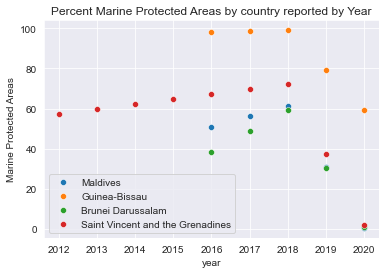

In [26]:
for country in anomalies:
    sns.scatterplot(data = epi[epi['country_name'] == country], x = 'year', y = 'Marine Protected Areas')

plt.legend(anomalies)
plt.title("Percent Marine Protected Areas by country reported by Year")
plt.show()

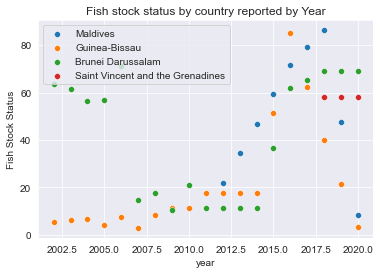

In [27]:
for country in anomalies:
    sns.scatterplot(data = epi[epi['country_name'] == country], x = 'year', y = 'Fish Stock Status')

plt.legend(anomalies)
plt.title("Fish stock status by country reported by Year")
plt.show()

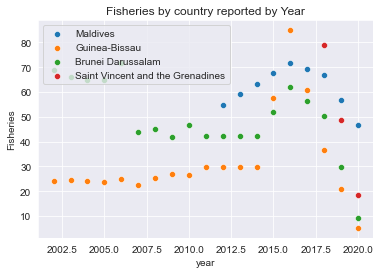

In [28]:
for country in anomalies:
    sns.scatterplot(data = epi[epi['country_name'] == country], x = 'year', y = 'Fisheries')

plt.legend(anomalies)
plt.title("Fisheries by country reported by Year")
plt.show()

- Decision: drop Saint Vincent and the Grenadines from our data, as we do not feel we can confidently impute null values from only three reported values in two categories (one of which shows significant volatility).

In [29]:
epi = epi[epi['country_name'] != 'Saint Vincent and the Grenadines']

- Inspect final column with high null count: Agricultural Subsidies.

In [30]:
ag_countries = set(epi[epi['Agricultural Subsidies'].isnull() == True]['country_name'].values)

In [31]:
full_ag_nulls = full_null_column(ag_countries, 'Agricultural Subsidies')

In [32]:
sorted(ag_countries) == sorted(full_ag_nulls)

True

- Impute regional values into each country. (TODO)

In [33]:
regional = pd.read_csv("./data/EPI_data/epi2020resultsregions20200604.csv")

In [34]:
regional_means = regional[[ 'country','AGR.rgn.mean']]

In [35]:
regional_means = regional_means[regional_means['country'].isin(ag_countries)]

In [36]:
regional_means[:5]

,country,AGR.rgn.mean
3,United Arab Emirates,36.512500
6,Antigua and Barbuda,32.653125
16,Bahrain,36.512500
17,Bahamas,32.653125
23,Barbados,32.653125


missing Libya and Palau from the regional data set. Use the value from another country from the same region to get the regional average. 

In [37]:
#for Libya use Egypt, since its in the same region:
regional[regional['country']=='Egypt']['AGR.rgn.mean']

50    36.5125
Name: AGR.rgn.mean, dtype: float64

In [38]:
regional_adds = {
    'country': "Libya",
    'AGR.rgn.mean':36.5125
    }

In [39]:
regional_means = regional_means.append(regional_adds, ignore_index=True)

In [40]:
# for palau use the Philippines which is is closest neighbor:
regional[regional['country']=='Philippines']['AGR.rgn.mean']

131    35.94
Name: AGR.rgn.mean, dtype: float64

In [41]:
regional_adds = {
    'country' : 'Palau',
    'AGR.rgn.mean':35.94
}

In [42]:
regional_means = regional_means.append(regional_adds, ignore_index=True)

In [43]:
regional_means.set_index(keys = 'country', inplace = True)

In [44]:
%%capture
for country in ag_countries:
    epi.loc[epi['country_name'].isin([country]), 'Agricultural Subsidies'] = regional_means.loc[country][0]    

C:\Users\DanAn\anaconda3secondinstall\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


- Inspect other less frequently null columns.

In [45]:
some_nulls = epi.isnull().sum().sort_values(ascending = False)
some_nulls = [column for column, value in some_nulls.items() if value > 0]

In [46]:
countries_present = {}
for column in some_nulls:
    null_countries = set(epi[epi[column].isnull() == True]['country_name'].values)
    for country in null_countries:
        if country in countries_present:
            countries_present[country] = countries_present[country] + 1
        else:
            countries_present[country] = 1

In [47]:
countries_present

{'Brunei Darussalam': 1,
 'Guinea-Bissau': 1,
 'Maldives': 10,
 'Saint Lucia': 4,
 'Marshall Islands': 6,
 'Samoa': 4,
 'Sao Tome and Principe': 7,
 'Micronesia': 5,
 'Iraq': 1,
 'Somalia': 1}

In [48]:
frequent_null_countries = [country for country, value in countries_present.items() if value > 1]

In [49]:
frequent_null_countries

['Maldives',
 'Saint Lucia',
 'Marshall Islands',
 'Samoa',
 'Sao Tome and Principe',
 'Micronesia']

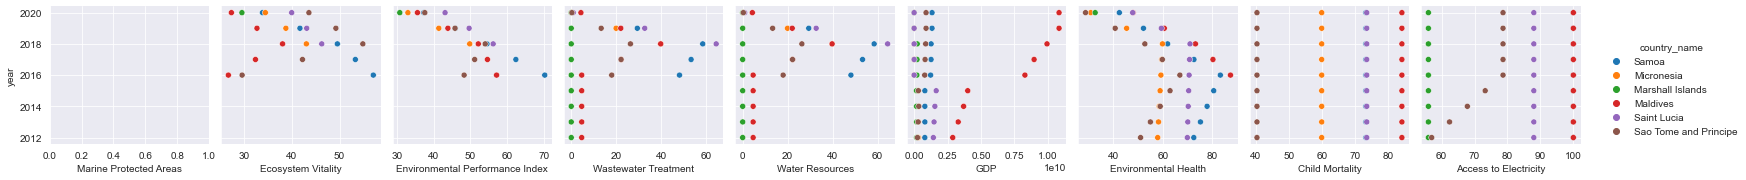

In [50]:
sns.pairplot(data = epi[epi['country_name'].isin(frequent_null_countries)], y_vars = 'year', x_vars = some_nulls[:9], hue = 'country_name')
plt.show()

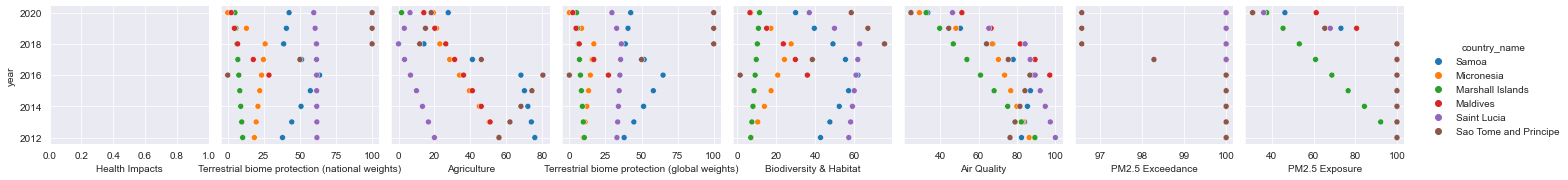

In [51]:
sns.pairplot(data = epi[epi['country_name'].isin(frequent_null_countries)], y_vars = 'year', x_vars = some_nulls[9:], hue = 'country_name')
plt.show()

- For similar reasons to the removal of Saint Vincent and the Grenadines, we are removing the Maldives, Samoa, Micronesia, Saint Lucia, the Marshall Islands, and Sao Tome and Principe from the data set. Reiteration of reasons: some categories contain too few non-null entries to confidently impute from, especially when some show high volatility.

In [52]:
epi = epi[~epi['country_name'].isin(frequent_null_countries)]

In [53]:
nulls = epi.isnull().sum().sort_values(ascending =False)
nulls[nulls > 0]

Marine Protected Areas    28
GDP                       13
dtype: int64

- Impute remaining nulls by padding using existing entries.

In [54]:
epi[epi['Marine Protected Areas'].isnull() == True]

,year,country_name,Unsafe sanitation,Sanitation & Drinking Water,Terrestrial biome protection (national weights),PM2.5 Exposure,Unsafe drinking water,Water Resources,Ecosystem Vitality,Agriculture,...,Health Impacts,Household Air Quality,Access to Electricity,Pesticide Regulation,Agricultural Subsidies,Child Mortality,Fisheries,Marine Protected Areas,Fish Stock Status,GDP
247,2002,Guinea-Bissau,0.000,4.190,89.870,100.000,8.380,0.00,38.450,52.0000,...,11.080,2.8,54.600,4.0,100.00,11.08,23.920,NaN,5.330,4.158435e+08
248,2003,Guinea-Bissau,0.000,4.660,89.870,100.000,9.320,0.00,38.560,52.0000,...,11.460,2.7,54.900,4.0,100.00,11.46,24.700,NaN,6.170,4.763883e+08
249,2004,Guinea-Bissau,0.150,5.230,89.870,100.000,10.310,0.00,38.490,52.0000,...,11.830,2.6,55.200,4.0,100.00,11.83,24.150,NaN,6.890,5.311094e+08
250,2005,Guinea-Bissau,0.310,5.830,89.870,100.000,11.350,0.00,38.410,52.0000,...,12.200,2.5,55.500,4.0,100.00,12.20,23.590,NaN,4.040,5.867919e+08
251,2006,Guinea-Bissau,0.480,6.460,89.870,100.000,12.450,0.00,38.570,52.0000,...,12.560,2.4,55.800,4.0,100.00,12.56,24.800,NaN,7.410,5.918299e+08
252,2007,Guinea-Bissau,0.640,7.130,89.870,100.000,13.610,0.00,38.280,52.0000,...,12.900,2.3,56.100,4.0,100.00,12.90,22.580,NaN,2.960,6.956063e+08
253,2008,Guinea-Bissau,0.810,7.830,89.870,100.000,14.850,0.00,38.890,56.0000,...,13.240,2.2,56.400,12.0,100.00,13.24,25.210,NaN,8.220,8.641367e+08
254,2009,Guinea-Bissau,0.980,8.570,89.870,100.000,16.160,0.00,39.110,56.0000,...,13.560,2.1,56.700,12.0,100.00,13.56,26.860,NaN,11.520,8.258287e+08
255,2010,Guinea-Bissau,1.150,9.350,89.870,100.000,17.560,0.00,39.090,56.0000,...,13.880,2.0,57.000,12.0,100.00,13.88,26.700,NaN,11.200,8.506333e+08
256,2011,Guinea-Bissau,1.320,10.190,89.870,100.000,19.060,0.00,39.520,56.0000,...,14.200,2.0,57.000,12.0,100.00,14.20,29.900,NaN,17.610,1.099386e+09


In [55]:
#TODO

- TODO: Somalia?

In [56]:
epi[epi['GDP'].isnull() == True]

,year,country_name,Unsafe sanitation,Sanitation & Drinking Water,Terrestrial biome protection (national weights),PM2.5 Exposure,Unsafe drinking water,Water Resources,Ecosystem Vitality,Agriculture,...,Health Impacts,Household Air Quality,Access to Electricity,Pesticide Regulation,Agricultural Subsidies,Child Mortality,Fisheries,Marine Protected Areas,Fish Stock Status,GDP
1337,2002,Somalia,2.14,1.07,3.43,100.00,0.00,3.96,6.04,50.0,...,14.01,2.6,26.6,0.0,100.0,14.01,0.0,0.0,0.0,NaN
1338,2003,Somalia,2.18,1.09,3.43,100.00,0.00,3.96,6.04,50.0,...,14.41,2.9,26.9,0.0,100.0,14.41,0.0,0.0,0.0,NaN
1339,2004,Somalia,2.21,1.11,3.43,100.00,0.00,3.96,6.04,50.0,...,14.82,3.2,27.2,0.0,100.0,14.82,0.0,0.0,0.0,NaN
1340,2005,Somalia,2.25,1.13,3.43,100.00,0.00,3.96,6.04,50.0,...,15.25,3.5,27.5,0.0,100.0,15.25,0.0,0.0,0.0,NaN
1341,2006,Somalia,2.30,1.15,3.43,100.00,0.00,3.96,6.04,50.0,...,15.71,3.8,27.8,0.0,100.0,15.71,0.0,0.0,0.0,NaN
1342,2007,Somalia,2.35,1.18,3.43,100.00,0.00,3.96,6.04,50.0,...,16.18,4.1,28.1,0.0,100.0,16.18,0.0,0.0,0.0,NaN
1343,2008,Somalia,2.41,1.20,3.43,100.00,0.00,3.96,6.04,50.0,...,16.65,4.4,28.4,0.0,100.0,16.65,0.0,0.0,0.0,NaN
1344,2009,Somalia,2.47,1.23,3.43,100.00,0.00,3.96,6.04,50.0,...,17.11,4.7,28.7,0.0,100.0,17.11,0.0,0.0,0.0,NaN
1345,2010,Somalia,2.52,1.26,3.43,100.00,0.00,3.96,6.50,56.0,...,17.58,5.0,29.0,12.0,100.0,17.58,0.0,0.0,0.0,NaN
1346,2011,Somalia,2.58,1.29,3.43,100.00,0.00,3.96,6.50,56.0,...,18.06,5.0,29.0,12.0,100.0,18.06,0.0,0.0,0.0,NaN
